# Benchmark Performance For Log Loss = Binary Cross Entropy

**Table of Contents** <a name="toc"></a>
- [1. Numpy vs different Cython implementations](#chapter_1)
  - [1.1 Implementation](#chapter_1_1)
  - [1.2. Simple Timings](#chapter_1_2)
  - [1.3 Benchmark Loss](#chapter_1_3)
  - [1.4 Benchmark Gradient](#chapter_1_4)
- [2. Numpy vs Loop Wrap - Numerical Stable Implementation](#chapter_2)
  - [2.1 Implementaion](#chapter_2_1)
  - [2.2 Benchmark Loss](#chapter_2_2)

In [1]:
%load_ext cython

In [2]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import subprocess
compiler = subprocess.run(['gcc', '--version'], stdout=subprocess.PIPE)
print(compiler.stdout.decode('utf-8'))

macOS-12.0.1-x86_64-i386-64bit
Python 3.9.7 (default, Sep  3 2021, 12:37:55) 
[Clang 12.0.5 (clang-1205.0.22.9)]
NumPy 1.21.4
SciPy 1.7.2
Apple clang version 13.0.0 (clang-1300.0.29.3)
Target: x86_64-apple-darwin21.1.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin



Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1


In [3]:
from collections import OrderedDict
import numpy as np
from scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurtu import delayed, timeit, Benchmark


# See https://github.com/mwaskom/seaborn/issues/1986
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height =5)
#g.map(plt.errorbar, "N", "mean", yerr=df.wall_time.reset_index()['std']);

# This works
# See https://stackoverflow.com/a/30428808
def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="line", ax=ax, **kwargs)

## 1. Numpy vs different Cython implementations <a name="chapter_1"></a>

### 1.1 Implementation <a name="chapter_1_1"></a>
With $\eta = \mathrm{raw\_prediction}$ and $\mathrm{y_{pred}} = expit(\eta) = \frac{exp(\eta)}{1 + exp(\eta)}$ we have
$$log\_loss =  log(1 + exp(\eta)) - y_{true} \eta$$

In [4]:
# numpy ufunc version
# Note: log1p(exp(x)) is faster than logaddexp(x)
def np_logloss(y_true, raw):
    # logaddexp(0, x) = log(1 + exp(x))
    # return np.logaddexp(0, raw) - y_true * raw
    #
    # numerically stable, but slower
    # pos = raw > 0
    # out = - y_true * raw
    # out[pos] += raw[pos] + np.log1p(np.exp(-raw[pos]))
    # out[~pos] += np.log1p(np.exp(raw[~pos]))
    # return out
    #
    # return np.where(raw >= 0, raw + np.log1p(np.exp(-raw)) - y_true * raw, np.log1p(np.exp(raw)) - y_true * raw)
    #
    # fast, but unstable for raw > 700
    return np.log1p(np.exp(raw)) - y_true * raw
    

def np_gradient(y_true, raw):
    return expit(raw) - y_true

In [5]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np
from scipy.special.cython_special cimport expit

np.import_array()


ctypedef double (*fpointer)(double, double) nogil


# Loop wrapper that takes function pointer and loops over samples
cdef inline void loop_wrap(fpointer f, double[::1] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    
    for i in range(size):
        out[i] = f(y_true[i], raw[i])


### 1. C level functions
cdef inline double c_logloss(double y_true, double raw) nogil:
    if raw <= 0:
        return log1p(exp(raw)) - y_true * raw
    else:
        # log(1 + exp(x)) = x + log(1 + exp(-x))
        return raw + log1p(exp(-raw)) - y_true * raw

    
cdef inline double c_gradient(double y_true, double raw) nogil:
        return expit(raw) - y_true


### 2. Cython function: loop over ndarray by calling C level functions
def cy_logloss(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out


def cy_gradient(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_gradient(y_true[i], raw[i])
        
    return out


### 3. loop over ndarray via loop wrapper, i.e. function pointer to C level functions
def cy_logloss_wrap(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    loop_wrap(c_logloss, y_true, raw, out)        
    return out


def cy_gradient_wrap(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    loop_wrap(c_gradient, y_true, raw, out)        
    return out


### 4. Class implementation, similar to 1. and 2.
cdef class Logloss():
    
    @staticmethod
    cdef inline double static_logloss(double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
    
    @staticmethod
    cdef inline double static_gradient(double y_true, double raw) nogil:
            return expit(raw) - y_true

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_logloss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)
        
        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = Logloss.static_gradient(y_true[i], raw[i])
            
        return np.asarray(out)

    def loss_wrap(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        loop_wrap(self.static_logloss, y_true, raw, out)
        return out
    
    def gradient_wrap(self, double[::1] y_true, double[::1] raw):
        cdef:
            cdef double[::1] out = np.empty_like(y_true)

        loop_wrap(self.static_gradient, y_true, raw, out)
        return out


### 5. Class using virtual inheritance, i.e. loop in base class
# is inherited to derived class
cdef class BaseLoss():

    cdef double _loss(self, double y_true, double raw) nogil:
        return 1.
    
    cdef double _gradient(self, double y_true, double raw) nogil:
        return 1.

    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._loss(y_true[i], raw[i])
            
        return np.asarray(out)
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples
            int i
            cdef double[::1] out = np.empty_like(y_true)

        n_samples = y_true.shape[0]
        for i in range(n_samples):
            out[i] = self._gradient(y_true[i], raw[i])
            
        return np.asarray(out)


cdef class Logloss_virtual(BaseLoss):

    cdef inline double _loss(self, double y_true, double raw) nogil:
        if raw <= 0:
            return log1p(exp(raw)) - y_true * raw
        else:
            # log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + log1p(exp(-raw)) - y_true * raw
        
    cdef inline double _gradient(self, double y_true, double raw) nogil:
        return expit(raw) - y_true

In [6]:
%%cython -3
# distutils: language = c++
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False


### 6. C++ template function loop wrapper
# We use functors, i.e. structs, in order
# to be sure, that the function call inside
# the template function gets inlined.
# See https://stackoverflow.com/a/2156899
#
# For further tricks, see also
# https://stackoverflow.com/questions/53582945/wrapping-c-code-with-function-pointer-as-template-parameter-in-cython

import cython
import numpy as np

cimport numpy as np
np.import_array()


cdef extern from *:
    """
#include <cmath>
#ifdef _OPENMP
#include <omp.h>
#endif /* _OPENMP */


inline double expit(double x) {
    return 1 / (1 + std::exp(-x));
};


struct cpp_logloss {
    inline double operator()(double y_true, double raw) {
        if (raw <= 0) {
            return std::log1p(std::exp(raw)) - y_true * raw;
        } else {
            // log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + std::log1p(std::exp(-raw)) - y_true * raw;
        }
    }
};

    
struct cpp_gradient {
    inline double operator()(double y_true, double raw) {
        return expit(raw) - y_true;
    }
};
   
   
    
template<typename F>
void loop_template(F f, double* y_true, double* raw, double* out, int n_samples) {
    for(int i = 0; i < n_samples; ++i){
        out[i] = f(y_true[i], raw[i]);
    }
}


template<typename Derived>
class BaseLossFunction {
public:
    void loss(double* y_true, double* raw, double* out, int n_samples) {
        for(int i = 0; i < n_samples; ++i) {
            out[i] = static_cast<Derived*>(this)->_loss(y_true[i], raw[i]);
        }
    };
    
    void gradient(double* y_true, double* raw, double* out, int n_samples) {
        for(int i = 0; i < n_samples; ++i) {
            out[i] = static_cast<Derived*>(this)->_gradient(y_true[i], raw[i]);
        }
    };

// https://www.fluentcpp.com/2017/05/12/curiously-recurring-template-pattern/
private:
    BaseLossFunction(){};
    friend Derived;
};


class Logloss_CRTP_cpp : public BaseLossFunction<Logloss_CRTP_cpp> {
public:
    inline double _loss(double y_true, double raw) {
        if (raw <= 0) {
            return std::log1p(std::exp(raw)) - y_true * raw;
        } else {
            // log(1 + exp(x)) = x + log(1 + exp(-x))
            return raw + std::log1p(std::exp(-raw)) - y_true * raw;
        }
    };
    
    inline double _gradient(double y_true, double raw) {
        return expit(raw) - y_true;
    };
};
    """
    void loop_template[F](F, double*, double*, double*, int)
    cppclass cpp_logloss:
        double operator()(double, double)
    cppclass cpp_gradient:
        double operator()(double, double)
    cppclass Logloss_CRTP_cpp:
        Logloss_CRTP_cpp() except +
        void loss(double* , double* , double* , int)
        void gradient(double* , double* , double* , int)


def cy_logloss_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        double[::1] out = np.empty_like(y_true)
        cpp_logloss f

    loop_template(f, &y_true[0], &raw[0], &out[0], n_samples)
    return out


def cy_gradient_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        double[::1] out = np.empty_like(y_true)
        cpp_gradient f
    
    loop_template(f, &y_true[0], &raw[0], &out[0], n_samples)        
    return out


cdef class Logloss_CRTP:
    cdef Logloss_CRTP_cpp c_loss  # Hold a C++ instance which we're wrapping
    
    def __cinit__(self):
        self.c_loss = Logloss_CRTP_cpp()
    
    def loss(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples = y_true.shape[0]
            double[::1] out = np.empty_like(y_true)
        
        self.c_loss.loss(&y_true[0], &raw[0], &out[0], n_samples)
        return out
    
    def gradient(self, double[::1] y_true, double[::1] raw):
        cdef:
            int n_samples = y_true.shape[0]
            double[::1] out = np.empty_like(y_true)
        
        self.c_loss.gradient(&y_true[0], &raw[0], &out[0], n_samples)
        return out

### 1.2. Simple Timings <a name="chapter_1_2"></a>
[back to TOC](#toc)

In [7]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = rng.standard_normal(100_000, dtype=np.float64)

In [8]:
[np.sum(np_logloss(y_true, raw) - cy_logloss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - cy_logloss_wrap(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss().loss_wrap(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss_virtual().loss(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - cy_logloss_template(y_true, raw)),
 np.sum(np_logloss(y_true, raw) - Logloss_CRTP().loss(y_true, raw)),
]

[1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14,
 1.9872992140790302e-14]

In [9]:
obj_Logloss = Logloss()
obj_Logloss_virtual = Logloss_virtual()
obj_Logloss_CRTP = Logloss_CRTP()

In [10]:
%%timeit -r10 -n100
np_logloss(y_true, raw)

1.36 ms ± 91.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [11]:
%%timeit -r10 -n100
cy_logloss(y_true, raw)

2.6 ms ± 100 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [12]:
%%timeit -r10 -n100
cy_logloss_wrap(y_true, raw)

2.57 ms ± 90.5 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [13]:
%%timeit -r10 -n100
obj_Logloss.loss(y_true, raw)

2.57 ms ± 104 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [14]:
%%timeit -r10 -n100
obj_Logloss.loss_wrap(y_true, raw)

2.57 ms ± 103 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [15]:
%%timeit -r10 -n100
obj_Logloss_virtual.loss(y_true, raw)

2.67 ms ± 98.5 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [16]:
%%timeit -r10 -n100
cy_logloss_template(y_true, raw)

2.51 ms ± 106 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [17]:
%%timeit -r10 -n100
obj_Logloss_CRTP.loss(y_true, raw)

2.48 ms ± 100 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [18]:
[np.sum(np_gradient(y_true, raw) - cy_gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - cy_gradient_wrap(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss().gradient_wrap(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss_virtual().gradient(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - cy_gradient_template(y_true, raw)),
 np.sum(np_gradient(y_true, raw) - Logloss_CRTP().gradient(y_true, raw)),
]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [19]:
%%timeit -r10 -n500
np_gradient(y_true, raw)

630 µs ± 21.7 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [20]:
%%timeit -r10 -n500
cy_gradient(y_true, raw)

695 µs ± 21.6 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [21]:
%%timeit -r10 -n500
cy_gradient_wrap(y_true, raw)

705 µs ± 18.2 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [22]:
%%timeit -r10 -n500
obj_Logloss.gradient(y_true, raw)

699 µs ± 14 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [23]:
%%timeit -r10 -n500
obj_Logloss.gradient_wrap(y_true, raw)

706 µs ± 14.2 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [24]:
%%timeit -r10 -n500
obj_Logloss_virtual.gradient(y_true, raw)

855 µs ± 20.3 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [25]:
%%timeit -r10 -n500
cy_gradient_template(y_true, raw)

550 µs ± 13.5 µs per loop (mean ± std. dev. of 10 runs, 500 loops each)


In [26]:
%%timeit -r10 -n100
obj_Logloss_CRTP.gradient(y_true, raw)

555 µs ± 29.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


### 1.3 Benchmark Loss <a name="chapter_1_3"></a>
[back to TOC](#toc)

In [27]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_logloss, "np_logloss"),
             (cy_logloss, "cy_logloss"),
             (cy_logloss_wrap, "cy_logloss_wrap"),
             (Logloss().loss, "Logloss().loss"),
             (Logloss().loss_wrap, "Logloss().loss_wrap"),
             (Logloss_virtual().loss, "Logloss_virtual().loss"),
             (cy_logloss_template, "cy_logloss_template"),
             (Logloss_CRTP().loss, "Logloss_CRTP().loss"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [28]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss = bench(benchmark_cases())

  0%|          | 0/3200 [00:00<?, ?it/s]

CPU times: user 17min 29s, sys: 1min 41s, total: 19min 10s
Wall time: 19min 56s


In [29]:
df = df_loss
df.head()

wall_time                         peak_memory       \
                               mean       max           std        mean  max   
N  function                                                                    
10 Logloss().loss          0.000006  0.000011  1.354381e-06         0.0  0.0   
   Logloss().loss_wrap     0.000005  0.000006  5.262663e-07         0.0  0.0   
   Logloss_CRTP().loss     0.000005  0.000006  3.888113e-07         0.0  0.0   
   Logloss_virtual().loss  0.000006  0.000009  9.265622e-07         0.0  0.0   
   cy_logloss              0.000005  0.000005  1.207137e-07         0.0  0.0   

                                
                           std  
N  function                     
10 Logloss().loss          0.0  
   Logloss().loss_wrap     0.0  
   Logloss_CRTP().loss     0.0  
   Logloss_virtual().loss  0.0  
   cy_logloss              0.0

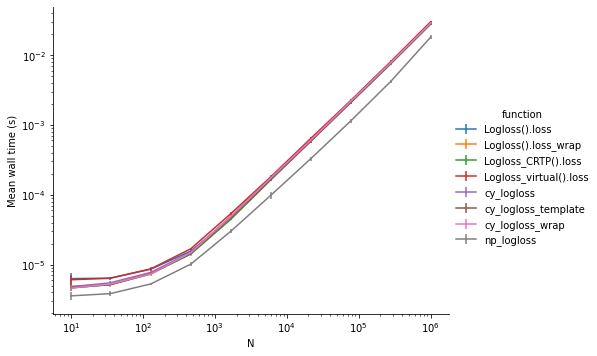

In [30]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

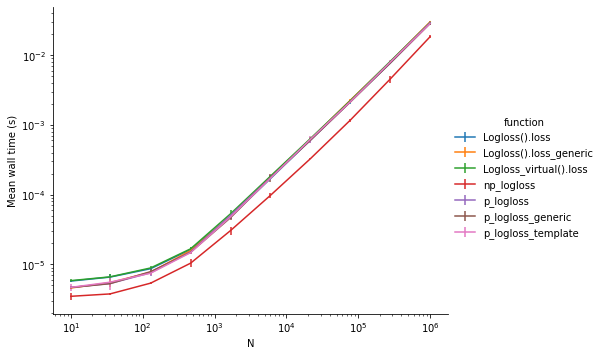

In [27]:
# OLD PLOT
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(xscale="log", yscale="log")
#g.set_axis_labels(y_var="Mean wall time (s)")
#g.add_legend()

Error propagation: $\sigma^2(x/y) \approx \left(\frac{\partial}{\partial x}\frac{x}{y}\right)^2 \sigma_x^2 + \left(\frac{\partial}{\partial y}\frac{x}{y}\right)^2 \sigma_y^2
= \frac{1}{y^2} \sigma_x^2 + \frac{x^2}{y^4} \sigma_y^2 $

In [31]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().loss,1.765739,0.441342
1,10,Logloss().loss_wrap,1.368255,0.229036
2,10,Logloss_CRTP().loss,1.301060,0.199167
3,10,Logloss_virtual().loss,1.700896,0.338740
4,10,cy_logloss,1.350023,0.176396


In [32]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().loss', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().loss_wrap', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().loss', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='cy_logloss', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='cy_logloss_wrap', 'N'] *= 1.10
df_plot.loc[df_plot['function'] =='cy_logloss_template', 'N'] *= 1.15
df_plot.loc[df_plot['function'] =='Logloss_CRTP().loss', 'N'] *= 1.20

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss')

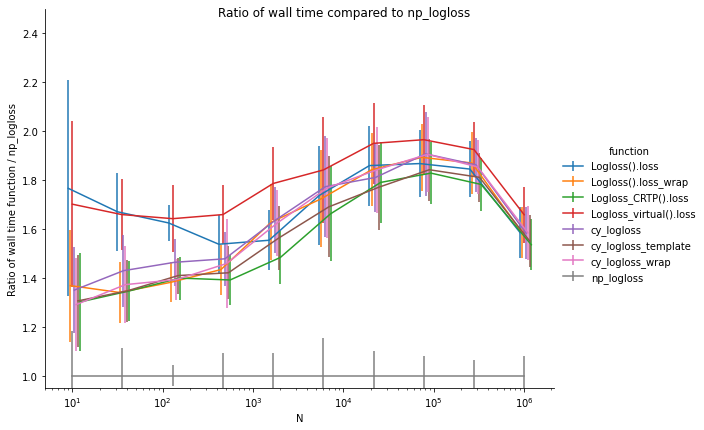

In [33]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(ylim=(0.95, 2.5))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss")

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss')

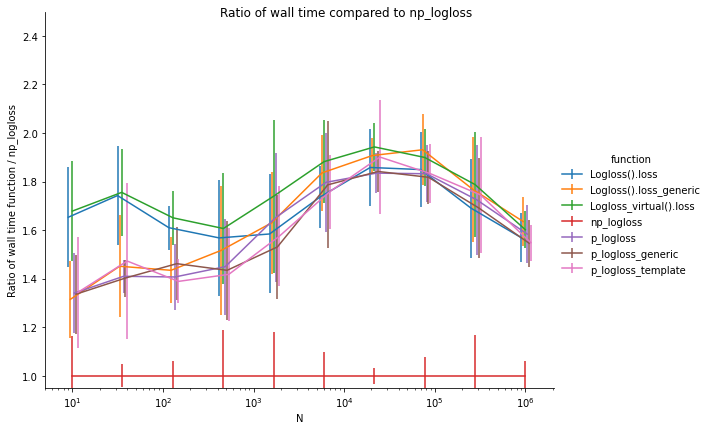

In [30]:
# OLD PLOT
#g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(ylim=(0.95, 2.5))
#g.set(xscale="log")
#g.set_axis_labels(y_var="Ratio of wall time function / np_logloss")
#g.add_legend()
#g.fig.suptitle("Ratio of wall time compared to np_logloss")

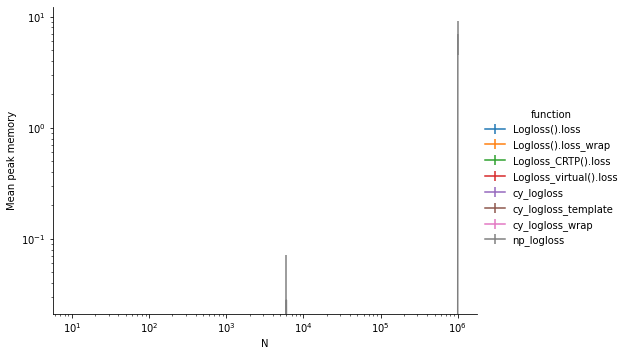

In [34]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

### 1.4 Benchmark Gradient <a name="chapter_1_4"></a>
[back to TOC](#toc)

In [35]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.standard_normal(n_samples)
raw = rng.standard_normal(n_samples)

func_list = [(np_gradient, "np_gradient"),
             (cy_gradient, "cy_gradient"),
             (cy_gradient_wrap, "cy_gradient_wrap"),
             (Logloss().gradient, "Logloss().gradient"),
             (Logloss().gradient_wrap, "Logloss().gradient_wrap"),
             (Logloss_virtual().gradient, "Logloss_virtual().gradient"),
             (cy_gradient_template, "cy_gradient_template"),
             (Logloss_CRTP().gradient, "Logloss_CRTP().gradient"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [36]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_gradient = bench(benchmark_cases())

  0%|          | 0/3200 [00:00<?, ?it/s]

CPU times: user 16min 31s, sys: 1min 57s, total: 18min 28s
Wall time: 19min 48s


In [37]:
df = df_gradient

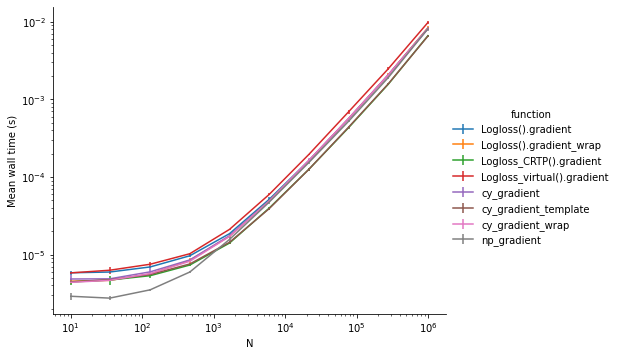

In [38]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

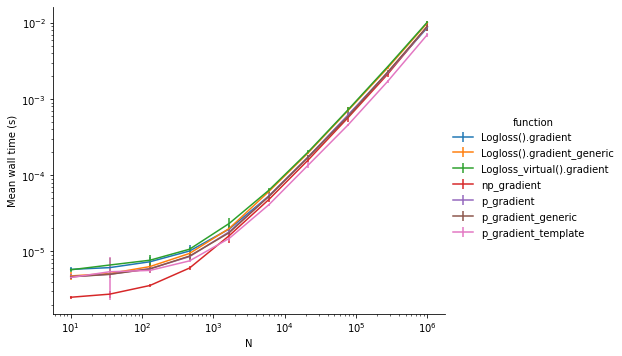

In [35]:
# OLD PLOT
#g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(xscale="log", yscale="log")
#g.set_axis_labels(y_var="Mean wall time (s)")
#g.add_legend()

In [39]:
df_reference = df.wall_time.reset_index().query("function == 'np_gradient'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,Logloss().gradient,2.007185,0.243065
1,10,Logloss().gradient_wrap,1.559332,0.197889
2,10,Logloss_CRTP().gradient,1.528244,0.209758
3,10,Logloss_virtual().gradient,2.000141,0.218231
4,10,cy_gradient,1.668658,0.262564


In [40]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='Logloss().gradient', 'N'] *= 0.9
df_plot.loc[df_plot['function'] =='Logloss().gradient_wrap', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='Logloss_virtual().gradient', 'N'] *= 1.00
df_plot.loc[df_plot['function'] =='cy_gradient', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='cy_gradient_wrap', 'N'] *= 1.10
df_plot.loc[df_plot['function'] =='cy_gradient_template', 'N'] *= 1.15
df_plot.loc[df_plot['function'] =='Logloss_CRTP().gradient', 'N'] *= 1.20

Text(0.5, 0.98, 'Ratio of wall time compared to np_gradient')

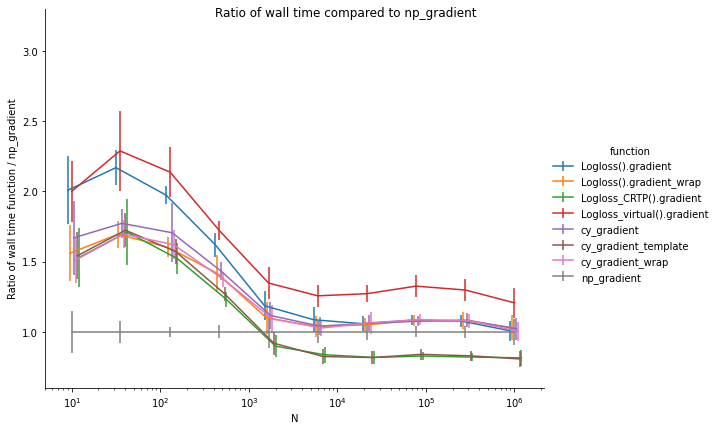

In [41]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log")
g.set(ylim=(0.6, 3.3))
g.set_axis_labels(y_var="Ratio of wall time function / np_gradient")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_gradient")

**Note:** The good performance of `cy_gradient_template` and `Logloss_CRTP().gradient` might come from the fact that `expit` is an inline function in these case.

Text(0.5, 0.98, 'Ratio of wall time compared to np_gradient')

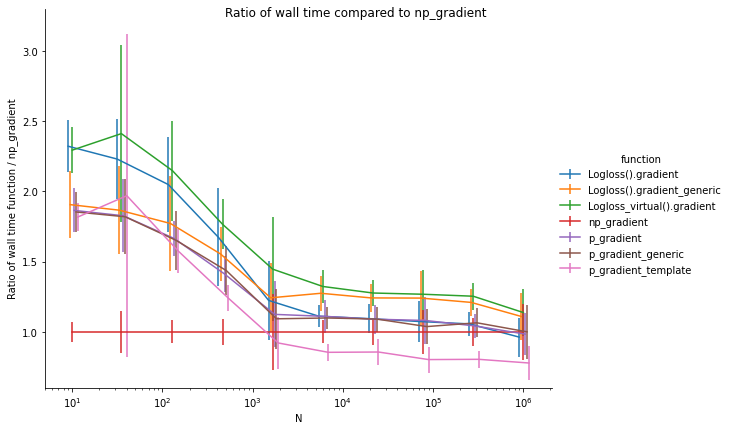

In [38]:
# OLD PLOT
#g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
#g.set(xscale="log")
#g.set(ylim=(0.6, 3.3))
#g.set_axis_labels(y_var="Ratio of wall time function / np_gradient")
#g.add_legend()
#g.fig.suptitle("Ratio of wall time compared to np_gradient")

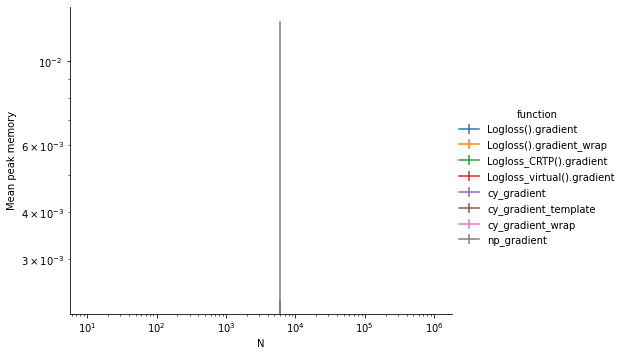

In [42]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

## 2. Numpy vs Loop Wrap - Numerical Stable Implementation <a name="chapter_2"></a>
[back to TOC](#toc)

See http://fa.bianp.net/blog/2019/evaluate_logistic/ and https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf as references on who to implement log loss in a numerically stable way.

### 2.1 Implementaion <a name="chapter_2_1"></a>
[back to TOC](#toc)

We use the more stable log

In [50]:
# 1. numpy ufunc version, this time the stable version
# Numerically stable log(1 + exp(x))
def np_log1pexp(x):
    return np.piecewise(x,
                        [x <= -37, (-37 < x) & (x <= 18), (18 < x) & (x <= 33.3), x > 33.3],
                        [lambda x: np.exp(x),
                         lambda x: np.log1p(np.exp(x)),
                         lambda x: x + np.exp(-x),
                         lambda x: x])

def np_logloss_stable(y_true, raw):
    return np_log1pexp(raw) - y_true * raw

def np_gradient_stable(y_true, raw):
    exp_tmp = exp(-raw)
    return ((1 - y_true) - y_true * exp_tmp) / (1 + exp_tmp)

In [51]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

# Compiler flags to detect non-vetorized loops:
# Sebastien Ponce "Practical Vectorization" CERN 2019
# https://indico.cern.ch/event/771113/contributions/3203712/attachments/1746730/3022094/PracticalVectorization.pres.pdf
# icc: -vec-report=5
# clang: -Rpass-missed=loop-vectorize -Rpass-analysis=loop-vectorize
# gcc: -fopt-info-vec-missed

import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np


np.import_array()


ctypedef double (*fpointer)(double, double) nogil


cdef inline void loop_wrap(fpointer f, double[::1] y_true, double[::1] raw, double[::1] out):
    cdef:
        int i
        int size = y_true.shape[0]
    with nogil:
        for i in range(size):
            out[i] = f(y_true[i], raw[i])
            
            
cdef double sum_wrap(fpointer f, double[::1] y_true, double[::1] raw):
    cdef:
        int i
        int size = y_true.shape[0]
        double out = 0.
    with nogil:
        for i in range(size):
            out += f(y_true[i], raw[i])
        return out


# Numerically stable log(1 + exp(x))
cdef inline double log1pexp(double x) nogil:
    if x <= -37:
        return exp(x)
    elif x <= 18:
        return log1p(exp(x))
    elif x <= 33.3:
        return x + exp(-x)
    else:
        return x


cdef inline double c_logloss(double y_true, double raw) nogil:
    return log1pexp(raw) - y_true * raw
    

cdef inline double c_gradient(double y_true, double raw) nogil:
    exp_tmp = exp(-raw)
    return ((1 - y_true) - y_true * exp_tmp) / (1 + exp_tmp)


### 2. Cython function: loop over ndarray by calling C level functions
def cy_logloss_stable(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return out

def cy_logloss_stable_sum(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        double out = 0.
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out += c_logloss(y_true[i], raw[i])

    return out

def cy_gradient_stable(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        cdef double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_gradient(y_true[i], raw[i])
        
    return out


### 3. loop over ndarray via loop wrapper, i.e. function pointer to C level functions
def cy_logloss_stable_wrap(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    loop_wrap(c_logloss, y_true, raw, out)        
    return out

def cy_logloss_stable_sum_wrap(double[::1] y_true, double[::1] raw):
    cdef double out = 0
    
    out = sum_wrap(c_logloss, y_true, raw)
    return out

def cy_gradient_stable_wrap(double[::1] y_true, double[::1] raw):
    cdef:
        cdef double[::1] out = np.empty_like(y_true)
    
    loop_wrap(c_gradient, y_true, raw, out)        
    return out

In [63]:
%%cython -3
# distutils: language = c++
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False


### 4. C++ template function loop wrapper
# We use functors, i.e. structs, in order
# to be sure, that the function call inside
# the template function gets inlined.
# See https://stackoverflow.com/a/2156899
#
# For further tricks, see also
# https://stackoverflow.com/questions/53582945/wrapping-c-code-with-function-pointer-as-template-parameter-in-cython

import cython
import numpy as np

cimport numpy as np
np.import_array()


cdef extern from *:
    """
#include <cmath>
#ifdef _OPENMP
#include <omp.h>
#endif /* _OPENMP */


inline double cpp_log1pexp(double x) {
    if (x <= -37) {
        return std::exp(x);
    } else if (x <= 18) {
        return std::log1p(std::exp(x));
    } else if (x <= 33.3) {
        return x + std::exp(-x);
    } else {
        return x;
    }
};


struct cpp_logloss {
    /* inline here has no effect, it is already inlined */
    double operator()(double y_true, double raw) {
        return cpp_log1pexp(raw) - y_true * raw;
    }
};


template<typename F>
void loop_template(F f, double* y_true, double* raw, double* out, int n_samples) {
    for(int i = 0; i < n_samples; ++i) {
        out[i] = f(y_true[i], raw[i]);
    }
}

template<typename F>
double sum_template(F f, double* y_true, double* raw, int n_samples) {
    double out = 0;
    for(int i = 0; i < n_samples; ++i) {
        out += f(y_true[i], raw[i]);
    }
    return out;
}
    """
    void loop_template[F](F, double*, double*, double*, int) nogil
    double sum_template[F](F, double*, double*, int) nogil
    cppclass cpp_logloss:
        double operator()(double, double) nogil


def cy_logloss_stable_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        cdef double[::1] out = np.empty_like(y_true)
        cpp_logloss f
    
    loop_template(f, &y_true[0], &raw[0], &out[0], n_samples)
    return out


def cy_logloss_stable_sum_template(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples = y_true.shape[0]
        cpp_logloss f
        double out
    
    out = sum_template(f, &y_true[0], &raw[0], n_samples)
    return out

In [53]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = 20 * rng.standard_normal(100_000, dtype=np.float64)  # make sure some values are <= -37 and > 33

In [54]:
raw.min(), raw.max()

(-91.87980390791544, 85.34683410460212)

In [55]:
# Same result on simple input
np_logloss(0.2, 0.5) - np_logloss_stable(0.2, 0.5)

0.0

In [56]:
np.sum(np.abs(np_logloss(y_true, raw) - np_logloss_stable(y_true, raw)))

5.826450433232822e-13

In [57]:
np.sum(np.abs(np_logloss(y_true, raw) - cy_logloss_stable_template(y_true, raw)))

5.826450433232822e-13

In [58]:
%%timeit -r20 -n50
np_logloss(y_true, raw)

1.49 ms ± 88.9 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [59]:
%%timeit -r20 -n50
np_logloss_stable(y_true, raw)

3.01 ms ± 140 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [60]:
%%timeit -r20 -n50
cy_logloss_stable(y_true, raw)

2.08 ms ± 93.7 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [61]:
%%timeit -r20 -n50
cy_logloss_stable_wrap(y_true, raw)

2.14 ms ± 97.3 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [64]:
%%timeit -r20 -n50
cy_logloss_stable_template(y_true, raw)

2.18 ms ± 109 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [65]:
(np.sum(np_logloss_stable(y_true, raw)),
 cy_logloss_stable_sum(y_true, raw),
 cy_logloss_stable_sum_wrap(y_true, raw),
 cy_logloss_stable_sum_template(y_true, raw),
)

(800208.506890483, 800208.5068904647, 800208.5068904647, 800208.5068904647)

In [66]:
%%timeit -r20 -n50
np.sum(np_logloss_stable(y_true, raw))

3.04 ms ± 120 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [67]:
%%timeit -r20 -n50
np.sum(cy_logloss_stable(y_true, raw))

2.12 ms ± 115 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [68]:
%%timeit -r20 -n50
cy_logloss_stable_sum(y_true, raw)

2.17 ms ± 115 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [69]:
%%timeit -r20 -n50
cy_logloss_stable_sum_wrap(y_true, raw)

2.1 ms ± 91.7 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


In [70]:
%%timeit -r20 -n50
cy_logloss_stable_sum_template(y_true, raw)

2.13 ms ± 94 µs per loop (mean ± std. dev. of 20 runs, 50 loops each)


**Note: numpy.sum() is so fast, there is no need to implement a separate "loop sum wrapper".**

### 2.2 Benchmark Loss <a name="chapter_2_2"></a>
[back to TOC](#toc)

In [71]:
n_samples = 1000_000
rng = np.random.default_rng(42)
y_true = rng.binomial(1, 0.5, size=n_samples).astype(np.float64)
raw = 20 * rng.standard_normal(n_samples, dtype=np.float64)

func_list = [(np_logloss_stable, "np_logloss_stable"),
             (cy_logloss_stable, "cy_logloss_stable"),
             (cy_logloss_stable_wrap, "cy_logloss_stable_wrap"),
             (cy_logloss_stable_template, "cy_logloss_stable_template"),
            ]

def benchmark_cases():
    for N in np.logspace(np.log10(10), np.log10(n_samples), 10).astype('int'):
        for func, name in func_list:
            tags = OrderedDict(N=N, function=name)
            yield delayed(func, tags=tags)(y_true[:N], raw[:N])

In [72]:
%%time
bench = Benchmark(wall_time={'number': 1}, peak_memory=True, repeat=20)
df_loss_stable = bench(benchmark_cases())

  0%|          | 0/1600 [00:00<?, ?it/s]

CPU times: user 9min 17s, sys: 1min 5s, total: 10min 23s
Wall time: 11min 2s


In [73]:
df = df_loss_stable
df.head()

wall_time                         peak_memory  \
                                   mean       max           std        mean   
N  function                                                                   
10 cy_logloss_stable           0.000005  0.000007  5.872212e-07         0.0   
   cy_logloss_stable_template  0.000005  0.000007  4.848441e-07         0.0   
   cy_logloss_stable_wrap      0.000005  0.000007  4.856832e-07         0.0   
   np_logloss_stable           0.000039  0.000050  3.828691e-06         0.0   
35 cy_logloss_stable           0.000005  0.000007  5.159748e-07         0.0   

                                         
                               max  std  
N  function                              
10 cy_logloss_stable           0.0  0.0  
   cy_logloss_stable_template  0.0  0.0  
   cy_logloss_stable_wrap      0.0  0.0  
   np_logloss_stable           0.0  0.0  
35 cy_logloss_stable           0.0  0.0

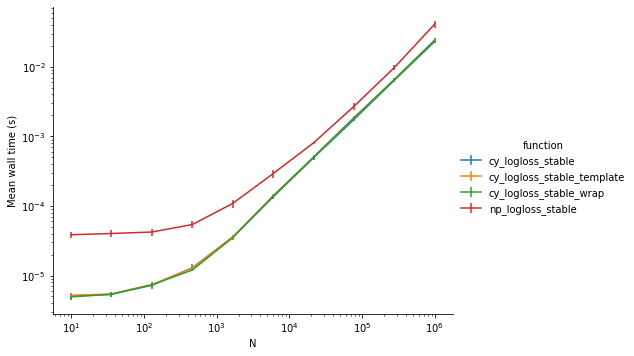

In [74]:
g = sns.FacetGrid(df.wall_time.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean wall time (s)")
g.add_legend()

In [75]:
df_reference = df.wall_time.reset_index().query("function == 'np_logloss_stable'")
df_plot = pd.merge(df.wall_time.reset_index(), df_reference, on='N', suffixes=('', '_np'))
df_plot['std'] = np.sqrt(df_plot['std']**2 / df_plot['mean_np']**2
                         + df_plot['mean']**2 / df_plot['mean_np']**4 * df_plot['std_np']**2)
df_plot['mean'] = df_plot['mean'] / df_plot['mean_np']
df_plot = df_plot.loc[:, ['N', 'function', 'mean', 'std']]
df_plot.head()

,N,function,mean,std
0,10,cy_logloss_stable,0.131114,0.020042
1,10,cy_logloss_stable_template,0.135202,0.018400
2,10,cy_logloss_stable_wrap,0.127829,0.017888
3,10,np_logloss_stable,1.000000,0.140468
4,35,cy_logloss_stable,0.133372,0.019629


In [76]:
# shift N slightly to make visualization easier
df_plot.loc[df_plot['function'] =='cy_logloss_stable', 'N'] *= 0.95
df_plot.loc[df_plot['function'] =='cy_logloss_stable_wrap', 'N'] *= 1.05
df_plot.loc[df_plot['function'] =='cy_logloss_stable_template', 'N'] *= 1.10

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss_stable')

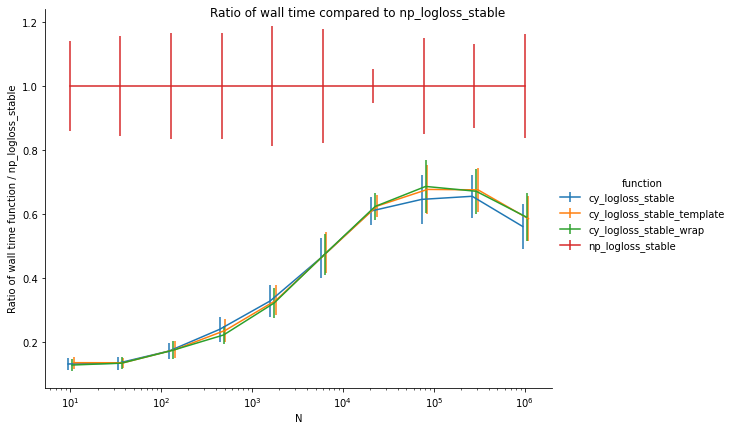

In [77]:
g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
#g.set(ylim=(0.95, 2.5))
g.set(xscale="log")
g.set_axis_labels(y_var="Ratio of wall time function / np_logloss_stable")
g.add_legend()
g.fig.suptitle("Ratio of wall time compared to np_logloss_stable")

Text(0.5, 0.98, 'Ratio of wall time compared to np_logloss_stable')

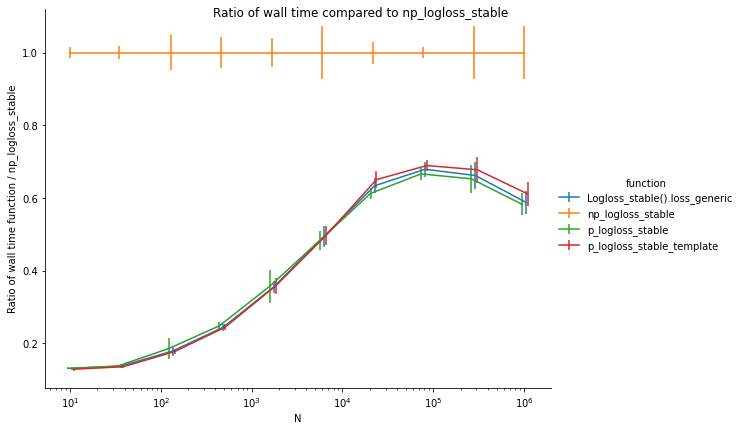

In [28]:
# OLD PLOT
#g = sns.FacetGrid(df_plot, hue="function", height=6, aspect=4/3)
#g.map_dataframe(errplot, "N", "mean", "std")
##g.set(ylim=(0.95, 2.5))
#g.set(xscale="log")
#g.set_axis_labels(y_var="Ratio of wall time function / np_logloss_stable")
#g.add_legend()
#g.fig.suptitle("Ratio of wall time compared to np_logloss_stable")

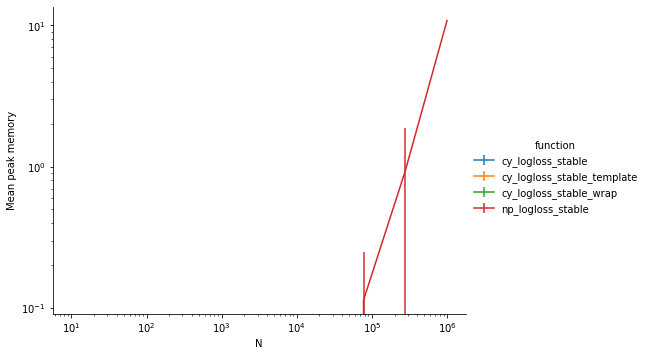

In [78]:
g = sns.FacetGrid(df.peak_memory.reset_index(), hue="function", height=5, aspect=4/3)
g.map_dataframe(errplot, "N", "mean", "std")
g.set(xscale="log", yscale="log")
g.set_axis_labels(y_var="Mean peak memory")
g.add_legend()

## 3. Improved Stable Implementation <a name="chapter_3"></a>
[back to TOC](#toc)

We can make the stable implementation a bit faster for the range -2 < x < 18, which may be the most important range!
The trick is to use `log(1 + x)` instead of `log1p(1 + x)` where this is save as `log` is a bit faster.

In [15]:
%%cython -3
# distutils: extra_compile_args = -O3
# cython: cdivision=True
# cython: boundscheck=False
# cython: wraparound=False

# Compiler flags to detect non-vetorized loops:
# Sebastien Ponce "Practical Vectorization" CERN 2019
# https://indico.cern.ch/event/771113/contributions/3203712/attachments/1746730/3022094/PracticalVectorization.pres.pdf
# icc: -vec-report=5
# clang: -Rpass-missed=loop-vectorize -Rpass-analysis=loop-vectorize
# gcc: -fopt-info-vec-missed


import cython
from cython.parallel import prange
import numpy as np

from libc.math cimport exp, log, log1p
cimport numpy as np


np.import_array()


# Numerically stable log(1 + exp(x))
cdef inline double log1pexp(double x) nogil:
    if x <= -37:
        return exp(x)
    elif x <= 18:
        return log1p(exp(x))
    elif x <= 33.3:
        return x + exp(-x)
    else:
        return x


# Faster version of numerically stable log(1 + exp(x))
cdef inline double log1pexp_fast(double x) nogil:
    if x <= -37:
        return exp(x)
    elif x <= -2:
        return log1p(exp(x))
    elif x <= 18:
        return log(1 + exp(x))
    elif x <= 33.3:
        return x + exp(-x)
    else:
        return x



cdef inline double c_logloss(double y_true, double raw) nogil:
    return log1pexp(raw) - y_true * raw
    

cdef inline double c_logloss_fast(double y_true, double raw) nogil:
    return log1pexp_fast(raw) - y_true * raw


def cy_logloss_stable(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss(y_true[i], raw[i])
        
    return np.asarray(out)


def cy_logloss_stable_fast(double[::1] y_true, double[::1] raw):
    cdef:
        int n_samples
        int i
        double[::1] out = np.empty_like(y_true)
    
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        out[i] = c_logloss_fast(y_true[i], raw[i])
        
    return np.asarray(out)

In file included from /Users/lorentzen/.ipython/cython/_cython_magic_e6acedb417c3ac16d97f29f80d843cc8.c:651:
In file included from /Users/lorentzen/github/python3_general/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/lorentzen/github/python3_general/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/lorentzen/github/python3_general/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/lorentzen/github/python3_general/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.


In [16]:
rng = np.random.default_rng(0)
y_true = rng.binomial(1, 0.5, size=100_000).astype(np.float64)
raw = rng.standard_normal(100_000, dtype=np.float64)

In [17]:
np.max(np.abs(cy_logloss_stable_fast(y_true, raw) - cy_logloss_stable(y_true, raw)))

4.440892098500626e-16

In [18]:
%%timeit -r10 -n100
cy_logloss_stable(y_true, raw)

2.22 ms ± 93.8 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [19]:
%%timeit -r10 -n100
cy_logloss_stable_fast(y_true, raw)

1.72 ms ± 81.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


Why the cutoff at -2?

In [22]:
def diff(x):
    """Return abs diff and rel diff"""
    use_log = np.log(1 + np.exp(x))
    use_log1p = np.log1p(np.exp(x))
    return use_log - use_log1p, use_log / use_log1p - 1

In [25]:
for x in [0, -1, -2, -3]:
    print(f"x={x}: {diff(x)}")

x=0: (0.0, 0.0)
x=-1: (0.0, 0.0)
x=-2: (1.1102230246251565e-16, 8.881784197001252e-16)
x=-3: (-1.0408340855860843e-16, -2.1094237467877974e-15)
